In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

In [207]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import integrate, linalg, optimize

%aimport models
import payoffs
import selection_functions

In [208]:
%matplotlib inline
plt.style.use("ggplot")

# Finding an equilibrium

Finding an equilibrium is easy, finding a *stable* equilibrium is more difficult.

In [184]:
optimize.least_squares?

In [217]:
# random initial guess
prng = np.random.RandomState()
x0, = prng.dirichlet(np.ones(4), 1)

# embed relevant params into the function f whose root is an equilibrium
UGA = lambda x_A: selection_functions.kirkpatrick_selection(x_A, 1.5)
UgA = lambda x_A: selection_functions.kirkpatrick_selection(x_A, 1)
payoff_kernel = payoffs.prisoners_dilemma_payoffs(prng)
f = lambda x: models.generalized_sexual_selection(x.reshape(-1,1), UGA, UgA, payoff_kernel, mutation_rate=1e-3).flatten()

In [218]:
# use non-linear solver to find the equilibrium
result = optimize.least_squares(f, x0, jac="3-point", bounds=(0.0, 1.0), gtol=1e-12)

0.700675087064 0.299324912936
0.70066903161 0.299324912936
0.700681142519 0.299324912936
0.700675087064 0.299318857481
0.700675087064 0.29933096839
0.70066903161 0.299324912936
0.700681142519 0.299324912936
0.700675087064 0.299318857481
0.700675087064 0.29933096839
0.801283006433 0.248636285085


AssertionError: 1-x_A should equal x_a; actual difference is -0.04991929151804603

In [202]:
result

 active_mask: array([0, 0, 0, 0])
        cost: 4.3955587969635061e-14
         fun: array([ -2.95410298e-07,  -1.92344596e-08,  -1.45823052e-08,
         7.83094767e-09])
        grad: array([  2.96801229e-07,  -8.36710669e-14,   1.59734395e-08,
        -8.48627332e-14])
         jac: array([[ -9.99998794e-01,  -1.81716371e-13,   4.92350261e-07,
         -1.81716371e-13],
       [ -5.14049948e-02,  -2.89331098e-01,  -5.14049350e-02,
         -2.89331054e-01],
       [  2.43038320e-08,  -7.46319093e-15,  -9.99999469e-01,
         -7.46319093e-15],
       [  5.14037643e-02,  -7.10668902e-01,   5.14039113e-02,
         -7.10668946e-01]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 20
        njev: 20
  optimality: 8.7678193354280249e-14
      status: 1
     success: True
           x: array([  2.95410480e-07,   2.89331070e-01,   1.45823127e-08,
         7.10668941e-01])

## Check stability

Asymptotic stability requires that the eigenvalues of the Jacobian matrix all have negative real parts.

In [203]:
f_jac = result["jac"]

In [206]:
eigvals = linalg.eigvals(f_jac)
np.all(np.real(eigvals) < 0.0)

True

# Interactive simulation

In [103]:
def plot_generalized_sexual_selection(x0=0.25, x1=0.25, x2=0.25, selection_function="kirkpatrick",
                                      d0=1, d2=1, T=10, R=6, P=4, S=0, mutation_rate=0.0, max_time=10):

    fig, ax = plt.subplots(1,1, figsize=(10,8))

    # prepare the axes
    ax.set_ylim((0, 1))
    ax.set_xlabel(r"Time, $t$", fontsize=15)
    ax.set_ylabel(r"Female genotype shares, $x_i$", fontsize=15)
    
    # create the initial condition
    x3 = 1 - (x0 + x1 + x2)
    y0=np.array([x0,x1,x2,x3])
    assert np.allclose(y0.sum(), 1)
    
    # create the payoff kernel
    assert T > R and R > P and R > S, "Payoffs must satisfy either Prisoner's Dilemma or Stag Hunt constraints!"
    payoff_kernel = np.array([[R, S],
                              [T, P]])
    
    # create the selection functions
    if selection_function == "kirkpatrick":
        UGA = lambda x_A: selection_functions.kirkpatrick_selection(x_A, d0)
        UgA = lambda x_A: selection_functions.kirkpatrick_selection(x_A, d2)
    elif selection_function == "seger":
        UGA = lambda x_A: selection_functions.seger_selection(x_A, d0)
        UgA = lambda x_A: selection_functions.seger_selection(x_A, d2)
    else:
      raise ValueError("selection_function must be one of \"kirkpatrick\" or \"seger\".")
    
    # simulate the model starting from a random initial condition
    f = lambda t, y: models.generalized_sexual_selection(y, UGA, UgA, payoff_kernel, mutation_rate)
    result = integrate.solve_ivp(f, t_span=(0, max_time), y0=y0, rtol=1e-9, atol=1e-12,
                                 dense_output=True, vectorized=True)
    
    ax.plot(result.t, result.y[0], label="GA")
    ax.plot(result.t, result.y[1], label="Ga")
    ax.plot(result.t, result.y[2], label="gA")
    ax.plot(result.t, result.y[3], label="ga")
    ax.legend()
    plt.show()

    return result

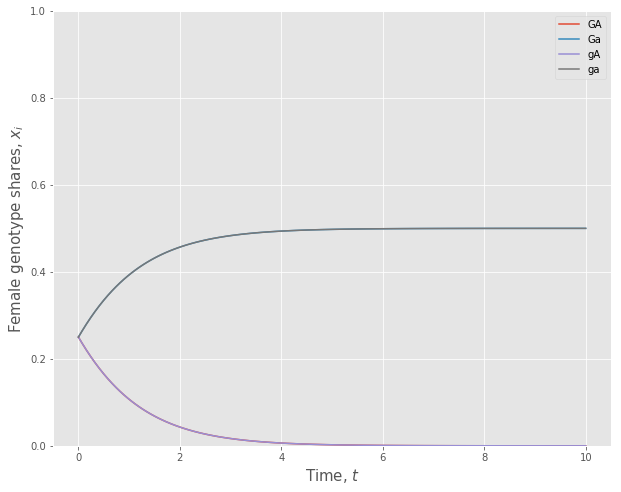

In [104]:
result = plot_generalized_sexual_selection(selection_function="kirkpatrick", T=50)

In [120]:
# sliders used to control the initial condition
x0_slider = widgets.FloatSlider(value=0.45, min=0.0, max=1.0, step=0.01, description=r"$x_0$")
x1_slider = widgets.FloatSlider(value=0.37, min=0.0, max=1.0, step=0.01, description=r"$x_1$")
x2_slider = widgets.FloatSlider(value=0.13, min=0.0, max=1.0, step=0.01, description=r"$x_2$")

# sliders used to control the Prisoner's Dilemma Payoffs
T_slider = widgets.FloatSlider(value=4, min=0, max=100, step=0.1, description=r"$T$")
R_slider = widgets.FloatSlider(value=3, min=0, max=100, step=0.1, description=r"$R$")
P_slider = widgets.FloatSlider(value=2, min=0, max=100, step=0.1, description=r"$P$")
S_slider = widgets.FloatSlider(value=1, min=0, max=100, step=0.1, description=r"$S$")

# slider used to control which selection function is being used
U_slider = widgets.Dropdown(options=["kirkpatrick", "seger"], index=0, description=r"$U$")

# slider that controls the parameters of the selection function
d0_slider = widgets.FloatSlider(value=1.5, min=0.0, max=10, step=0.05, description=r"$d_0$")
d2_slider = widgets.FloatSlider(value=1, min=0.0, max=10, step=0.05, description=r"$d_2$")

# slider used to control the mutation rate
e_slider = widgets.FloatSlider(value=0.01, min=0.0, max=1.0, step=1e-3, description=r"$\epsilon$", readout_format=".3f")

# slider that controls max simulation time
max_time_slider = widgets.IntSlider(value=500, min=10, max=2000, description=r"$\max t$")

w = widgets.interactive(plot_generalized_sexual_selection, x0=x0_slider, x1=x1_slider, x2=x2_slider,
                        selection_function=U_slider, d0=d0_slider, d2=d2_slider, 
                        T=T_slider, R=R_slider, P=P_slider, S=S_slider, 
                        mutation_rate=e_slider, max_time=max_time_slider)
display(w)

A Jupyter Widget

In [882]:
result.y.sum(axis=0)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])